In [719]:
import torch as tr
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [720]:
device = tr.device('cuda' if tr.cuda.is_available() else 'cpu')
# print(device)

In [721]:
def d(L,a=1):
    direction_mapping = [
        tr.tensor([0,1],dtype=tr.float).to(device), #up
        tr.tensor([0,-1],dtype=tr.float).to(device),#down
        tr.tensor([-1,0],dtype=tr.float).to(device), #left
        tr.tensor([1,0],dtype=tr.float).to(device) #right
    ]

    return tr.stack(direction_mapping).to(device)[L]*a

def custom_loss(output,target):
    diff = (output-target)**2
    loss = tr.mean(diff)

    return loss


In [722]:
#Agent Class
class Agent(nn.Module):
    def __init__(self, x, y):#initialize agent at location (-0.5,-0.5) with bias 0
        super(Agent, self).__init__()
        self.x=x #x coordinate
        self.y=y #y coordinate
        self.input = nn.Linear(4, 64,dtype=tr.float) #input layer
        self.hidden1 = nn.Linear(64, 64,dtype=tr.float) #hidden layer
        self.hidden2 = nn.Linear(64, 32, dtype = tr.float) #hidden layer
        self.output = nn.Linear(32, 4,dtype=tr.float) #output layer
        self.activation = nn.LeakyReLU() #activation function

    def forward(self, x): #forward pass
        x1 = self.activation(self.input(x))
        x2 = self.activation(self.hidden1(x1))
        x3 = self.activation(self.hidden2(x2))
        x4 = self.activation(self.output(x3))
        return x4
    

    def move(self,Q,e):

        L=tr.argmax(Q,dim=1)
        a = tr.tensor(0.0357,dtype=tr.float).to(device)
        dr = d(L,a)
        dx = dr[:,0]
        dy = dr[:,1]

        self.x+=dx
        self.y+=dy

def R(x,y,F,Q):
    #if (round(x,2),round(y,2))==(0.5,0.): return 10
    # u = F/tr.norm(F)
    # td = d(tr.argmax(Q))
    # dr = td*0.0357
    # e = td - u/tr.norm(td-u) #unit vector that when summed with F is parallel to td
    # v = e + F
    # dt = 0.0357/(tr.dot(v,dr))
    #return -dt.item()/1000
   
    dist = tr.stack([x-0.5,y],dim=1).to(device)
    return -tr.norm(dist,dim=1)

In [723]:
#Simulation Setup

def episode(agent,t_agent,t_update, max_steps,g,optimizer):
    
    X,Y = agent.x,agent.y
    for dT in range(max_steps):
        optimizer.zero_grad()                   #zero gradients

        if dT%t_update==0:              #update target agent every 100 steps
            t_agent.load_state_dict(agent.state_dict())
            #print(agent.x,agent.y)


        state = tr.stack([agent.x, agent.y, -tr.abs(agent.y), tr.zeros(agent.x.shape[0],dtype=tr.float).to(device)],dim=1) #state
        Q1 = agent.forward(state)#.transpose(0,1)) #Q value
        e = 1-dT/max_steps #epsilon
        agent.move(Q1,tr.tensor(e,dtype=tr.float).to(device))      	    #move agent

        state2 = tr.stack([agent.x, agent.y, -tr.abs(agent.y), tr.zeros(agent.x.shape[0],dtype=tr.float).to(device)],dim=1) #state
        Q2 = t_agent.forward(state2)#.transpose(0,1)) #Q value of target agent
        
        F = tr.stack([-agent.y,tr.zeros(agent.y.shape,dtype=tr.float).to(device)]).to(device)

        maxQ = tr.max(Q1,dim=1)[0]
        target = R(agent.x, agent.y, F, Q1)+ g*maxQ         #target Q value
        criterion = nn.MSELoss()
        loss = criterion(target,maxQ) #custom_loss(target,tr.max(Q1,dim=1)[0])      #loss


        #backpropagate
        loss.backward()

        #update weights                         
        optimizer.step()   
                             
        newX = X.reshape(128,-1)
        newY = Y.reshape(128,-1)
        newx = agent.x[:,None]
        newy = agent.y[:,None]
       
        X = tr.cat((newX,newx),dim=1)
        Y = tr.cat((newY,newy),dim=1)

    
    return X,Y



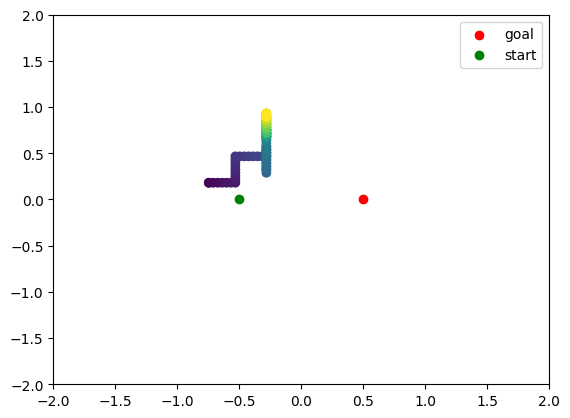

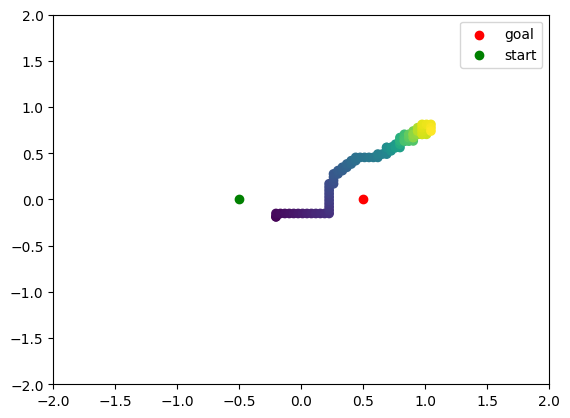

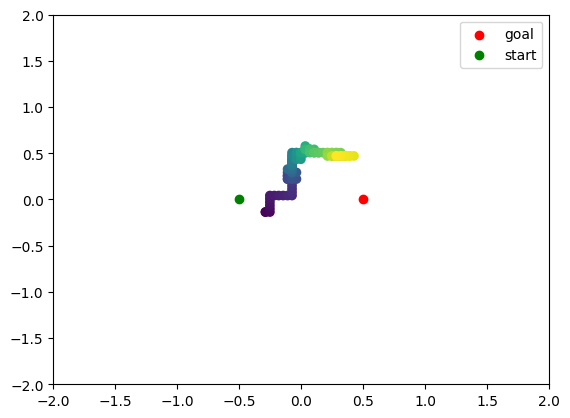

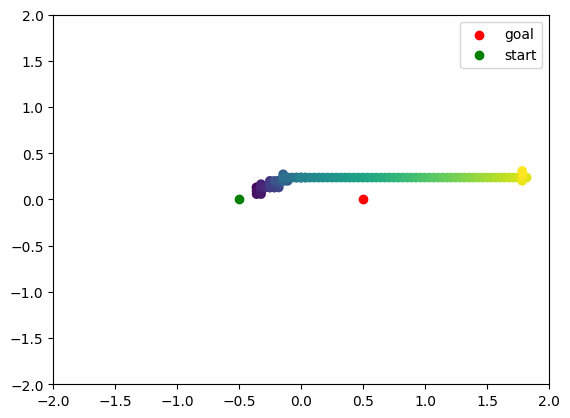

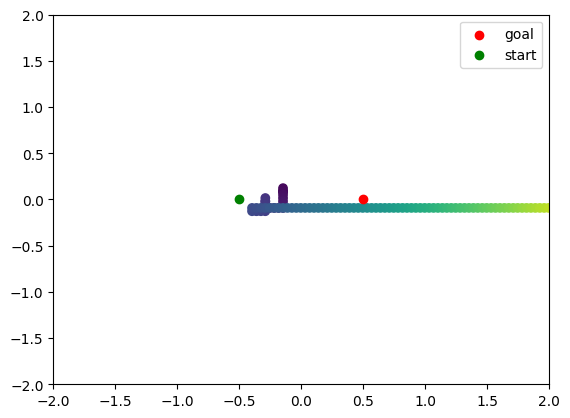

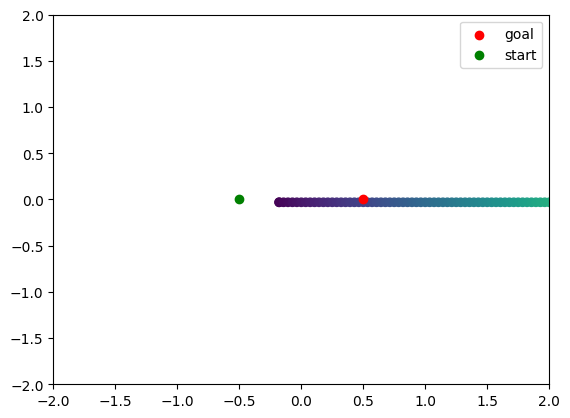

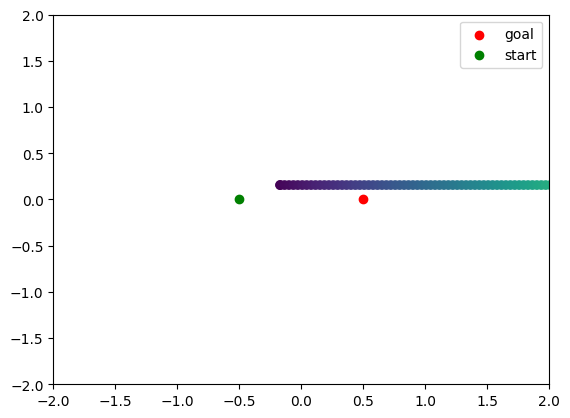

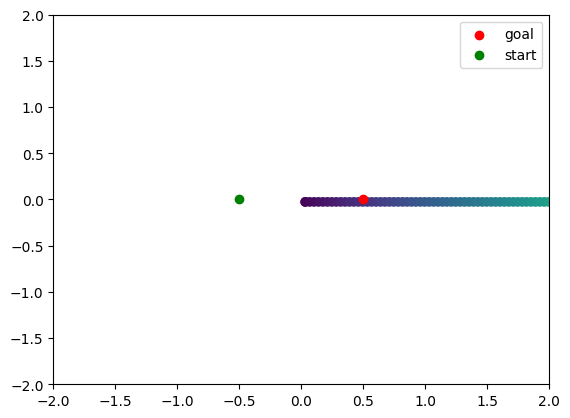

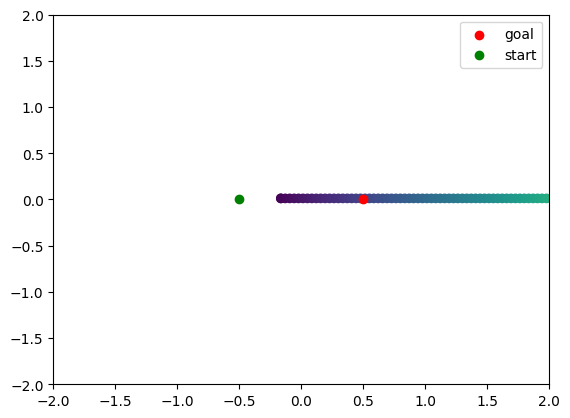

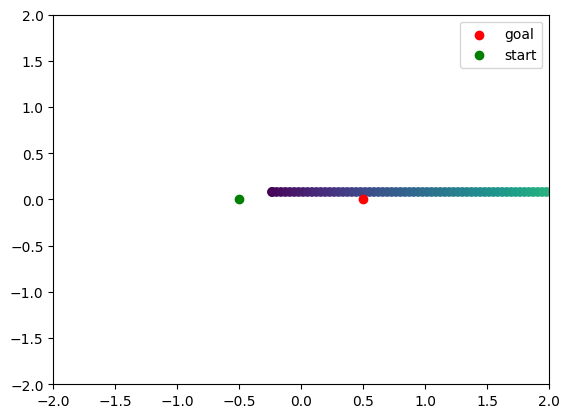

In [724]:
#Simulation

x = tr.randn(128, dtype=tr.float).to(device)/2-0.5
y = tr.randn(128, dtype=tr.float).to(device)/2
agent = Agent(x,y).to(device)

t_agent = Agent(x,y).to(device)
t_agent.load_state_dict(agent.state_dict()) #copies weights from agent to t_agent
t_agent.eval()

t_update = 100
optimizer = tr.optim.Adam(agent.parameters(), lr=0.001)

#X,Y = episode(agent, t_agent, t_update = 100, max_steps = 500, g=0.4, optimizer=optimizer)
for epoch in range(10):
    X,Y = episode(agent, t_agent, t_update = 100, max_steps = 100, g=0.4, optimizer=optimizer)
    agent.x = tr.randn(128, dtype=tr.float).to(device)/10-0.2
    agent.y = tr.randn(128, dtype=tr.float).to(device)/10
    x,y = X[0].detach().to('cpu').numpy(),Y[0].detach().to('cpu').numpy()
    
    plt.scatter(x,y,c=np.arange(len(x)),cmap='viridis')
    plt.scatter(0.5,0,c='r',label='goal')
    plt.scatter(-0.5,0,c='g',label='start')
    plt.legend()
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    plt.show()
